# This notebook will show how to use the ROSE framework to run a custom Active Learning strategy

In [2]:
import os
import sys

from rose.learner import ActiveLearner
from rose.metrics import MODEL_ACCURACY
from radical.flow import RadicalExecutionBackend, Task

%env RADICAL_LOG_LVL="DEBUG"
%env RADICAL_PROFILE="TRUE"

env: RADICAL_SMT=4
env: RADICAL_LOG_LVL="DEBUG"
env: RADICAL_PROFILE="TRUE"


## Custom Active Learning strategy:
In addition to the predefined workflows we saw in the `examples/basic/run_me.py`, the Active Learner API allows you to design custom active learning strategies tailored to your specific needs. This will allow you to define a flexible and iterative learning loop. For example, you could create a strategy that dynamically adjusts its behavior based on intermediate results, runs tasks in parallel, or incorporates additional utility tasks such as data cleaning or logging.

The following example demonstrates how to create a hybrid workflow that alternates between parallel simulation tasks and training and active learning tasks and incorporates a custom stopping condition based on model performance:

In [3]:
%env FLOW_JUPYTER_ASYNC=FALSE

engine = RadicalExecutionBackend({'runtime': 30,
                                  'resource': 'local.localhost'})
custom_acl = ActiveLearner(engine)

env: FLOW_JUPYTER_ASYNC=FALSE
RadicalPilot execution backend started successfully



In [4]:
code_path = f'{sys.executable} {os.getcwd()}'

print(code_path)

/home/aymen/ve/rct_debug_latest/bin/python3 /home/aymen/RADICAL/ROSE/examples/advanced


In [5]:
# Define and register the simulation task
@custom_acl.simulation_task
def simulation(*args):
    return Task(executable=f'{code_path}/simulation.py')

# Define and register the training task
@custom_acl.training_task
def training(*args):
    return Task(executable=f'{code_path}/training.py')

# Define and register the active learning task
@custom_acl.active_learn_task
def active_learn(*args):
    return Task(executable=f'{code_path}/active_learn.py')

# Defining the stop criterion with a metric (MSE in this case)
@custom_acl.as_stop_criterion(metric_name=MODEL_ACCURACY, threshold=0.99)
def check_accuracy(*args):
    return Task(executable=f'{code_path}/check_accuracy.py')

### Define your custom strategy and run it:
In this custom active learn-teach method, we will submit 3 simulation tasks in parallel and let the training task handle their output. In this example, we are targeting the Accuracy metric of the trained model, and we will stop if we trach an accuracy of 99%

In [6]:
def teach():
    # 10 iterations of active learning
    for acl_iter in range(10):
        print(f'Starting Iteration-{acl_iter}')
        simul = simulation()
        train = training(simul)
        active = active_learn(simul, train)
        check_result = check_accuracy(active).result()

        should_stop, metric_val = custom_acl.check_stop_criterion(check_result)

        if should_stop:
            print(f'Accuracy ({metric_val}) met the threshold, breaking...')
            break

teach()

Starting Iteration-0
stop criterion metric: model_accuracy is not met yet (0.95).
Starting Iteration-1
stop criterion metric: model_accuracy is not met yet (0.96).
Starting Iteration-2
stop criterion metric: model_accuracy is not met yet (0.95).
Starting Iteration-3
stop criterion metric: model_accuracy is not met yet (0.94).
Starting Iteration-4
stop criterion metric: model_accuracy is not met yet (0.96).
Starting Iteration-5
stop criterion metric: model_accuracy is not met yet (0.97).
Starting Iteration-6
stop criterion metric: model_accuracy is not met yet (0.97).
Starting Iteration-7
stop criterion metric: model_accuracy is not met yet (0.96).
Starting Iteration-8
stop criterion metric: model_accuracy is not met yet (0.95).
Starting Iteration-9
stop criterion metric: model_accuracy is not met yet (0.94).


Let's make sure to shutdown the resources.

In [7]:
engine.shutdown()

Shutdown is triggered, terminating the resources gracefully


### Plot the output:
Now, let's visualize the output of our custom Active learning strategy across N iterations.

Text(0.5, 1.0, 'ACC Values for Machine Learning Model')

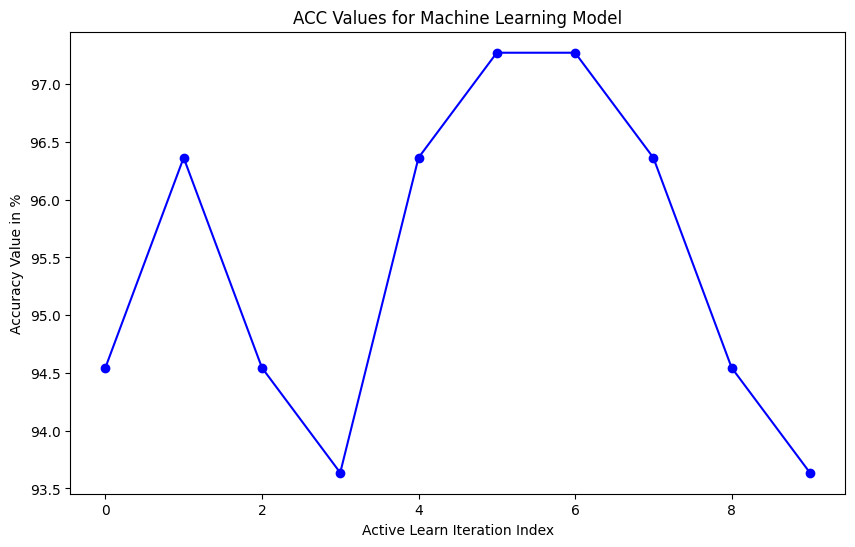

In [9]:
import matplotlib.pyplot as plt
# Convert string values to floats
mse_values = custom_acl.get_result(task_name='check_accuracy')
mse_values = [float(acc.strip()) * 100 for acc in mse_values]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.plot(mse_values, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Active Learn Iteration Index')
plt.ylabel('Accuracy Value in %')
plt.title('ACC Values for Machine Learning Model')